In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from RegularizingEmbeddings.lightning.model import SequenceModel
from RegularizingEmbeddings.data.data_generation import make_trajectories
import wandb
from omegaconf import DictConfig, OmegaConf

In [ ]:
def get_run(run_dict):
    _name = run_dict.name
    _epoch = run_dict.summary['epoch']
    _vloss = run_dict.summary['val_loss']
    _config = OmegaConf.create(run_dict.config)
    _file = os.path.join(*['outputs', *_name.split('_'),
                            'checkpoints', 'checkpoints',
                            f'model-epoch={_epoch:02d}-val_loss{_vloss:.4f}.ckpt'])

    # get model
    model = SequenceModel.load_from_checkpoint(_file).model
    model.eval()
    device = next(model.parameters()).device

    # get chaotic trajectory
    eq, sol, dt = make_trajectories(_config)

    return model, device, eq, sol, dt
    

In [ ]:
entity = "regularizing-embeddings"  # W&B entity
project = "regularizing-embeddings"  # W&B project

api = wandb.Api()
runs = api.runs(f"{entity}/{project}")

record = []
for run in runs:
    print(f"Run ID: {run.id}")
    print(f"Name: {run.name}")
    print(f"State: {run.state}")
    print(f"Created at: {run.created_at}")
    print(f"Summary: {run.summary}")
    print(f"Config: {run.config}")
    print("-" * 40)
    record.append(run)


Run ID: 3ksd71dg
Name: 2025-08-27_13-50-13
State: crashed
Created at: 2025-08-27T17:50:18Z
Summary: {'_runtime': 572.87894114, '_step': 289, '_timestamp': 1756317595.7470531, '_wandb': {'runtime': 572}, 'epoch': 72, 'train_loss_epoch': 1.5024938583374023, 'train_loss_step': 1.130514144897461, 'train_reg_loss_epoch': 2.86093581962632e-05, 'train_reg_loss_step': 3.369941987330094e-05, 'train_total_loss_epoch': 1.5025224685668943, 'train_total_loss_step': 1.1305478811264038, 'trainer/global_step': 7299, 'val_loss': 0.16228684782981873, 'val_reg_loss': 7.807563633832615e-06, 'val_total_loss': 0.1622946411371231}
Config: {'data': {'flow': {'dt': None, '_target_': 'RegularizingEmbeddings.dysts_sim.flows.Lorenz', 'random_state': 42}, 'postprocessing': {'low_pass': 10, 'high_pass': None, 'obs_noise': 0, 'filter_data': False, 'dims_to_observe': 'all'}, 'train_test_params': {'dtype': 'torch.FloatTensor', 'verbose': True, 'split_by': 'trajectory', 'seq_length': 25, 'seq_spacing': 1, 'test_percent

In [77]:
print(f'A total of {len(record)} runs are found')

A total of 35 runs are found


In [ ]:
# get model and dynamics data from chosen record
model, device, eq, sol, dt = get_run(record[0])
vals = sol['values'] # get actual values for system dynamics

2025-08-27 16:04:29.732 | INFO     | RegularizingEmbeddings.lightning.model:init_criterion:47 - Regularization lambda: 0.0010000000474974513, regularization: TanglingRegularization


In [ ]:
res = model(torch.tensor(vals, dtype = torch.float32).to(device))
# If res is a tuple (e.g., (output, ...)), get the first element
if isinstance(res, tuple):
    res_values = res[0]
else:
    res_valuesa = res

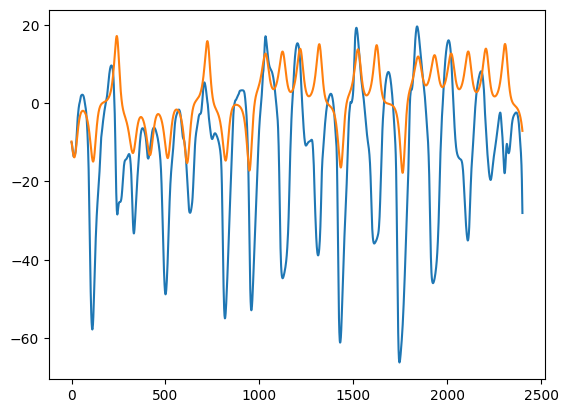

In [72]:
plt.figure()
plt.plot(res_values.cpu().detach().numpy()[0, :, 0])
plt.plot(vals[0, :, 0])

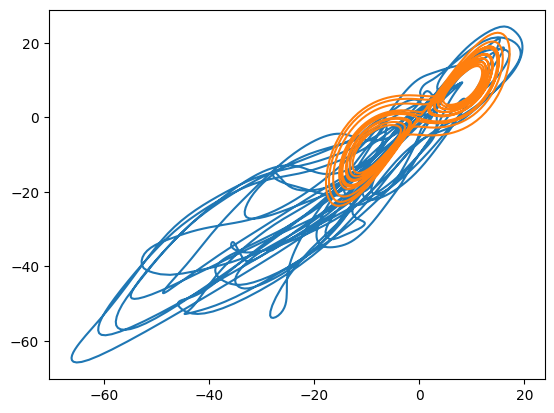

In [75]:
plt.figure()
plt.plot(res_values.cpu().detach().numpy()[0, :, 0], res_values.cpu().detach().numpy()[0, :, 1])
plt.plot(vals[0, :, 0], vals[0, :, 1])